# DAGs

Using the dag we craeted (not shown here), we determined that by controlling for parental income and GPA
we can get a causal effect of SAT scores on acceptance.

Let's create a simple logistic regression to see what we find.

\begin{align*}
    y &\sim \rm bernoulli \rm logit(\eta) \\
    \alpha &\sim \rm student\text{-}t(\alpha_{\rm df}, \alpha_{\rm loc}, \alpha_{\rm scale}) \\
    \beta &\sim \rm student\text{-}t(\beta_{\rm df}, \beta_{\rm loc}, \beta_{\rm scale}) \\
    \eta &= \alpha + X \beta \\
\end{align*}

For our causal inference model based on income, gpa, and SAT scores we have
\begin{align*}
    y &\sim \rm bernoulli \rm logit(\eta) \\
    \alpha &\sim \rm student\text{-}t(2, 0, 5) \\
    \beta &\sim \rm student\text{-}t(2, 0, 5) \\
    \eta &= \alpha + X \beta \\
\end{align*}

In [5]:
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from psis import *

import stan
import nest_asyncio
nest_asyncio.apply()

In [6]:
df = pd.read_csv("../data/02-processed/normalized_data.csv")
df.dropna(inplace=True)
df

,SUBJID,SATMath,SATWriting,SATVerbal,GPA,state,gender,race,income,choice,accepted,school,numapply,habits,SAT
0,884230,-1.652536,-1.777725,-1.719744,-0.688423,AL,Female,Black,4.439333,4.0,1.0,2192.0,9,6,-1.918234
1,884232,-1.845287,-1.681540,-1.324951,-2.113622,AL,Male,Black,4.243038,1.0,1.0,2192.0,6,6,-1.809764
2,884233,-1.845287,-2.739570,-2.805425,-3.776353,AL,Male,Black,4.653213,4.0,0.0,2192.0,4,4,-2.749835
3,884247,-0.592404,-0.623510,-0.239270,0.974309,AL,Female,Black,4.096910,1.0,1.0,2192.0,9,8,-0.544284
4,884307,-0.977906,-0.334957,-0.930158,-0.688423,AL,Male,Black,4.096910,4.0,1.0,2192.0,9,7,-0.833536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91259,886635,-3.098170,-1.008248,-2.015839,0.261710,FL,Female,Two or more race/ethnicity,5.397940,1.0,1.0,1691.0,6,5,-2.279800
91260,886640,0.467728,0.530704,0.451618,0.261710,FL,Female,White,4.942008,1.0,1.0,1691.0,3,7,0.540414
91261,886642,-0.110526,1.684918,1.339902,0.974309,FL,Female,Two or more race/ethnicity,4.829304,1.0,1.0,1691.0,9,6,1.082762
91262,886648,-0.399653,-0.912064,-0.535365,-0.688423,FL,Male,White,4.829304,2.0,1.0,1691.0,6,7,-0.688910


In [19]:
feature_cols = ["SAT", "GPA", "income"]
outcome_col = ["accepted"]

X_train, X_test, y_train, y_test = train_test_split(
    df[feature_cols],
    df[outcome_col],
    train_size=1_000,
    test_size=1_000,
    random_state=17)

In [20]:
# Convert dataframes to np arrays
X_train = X_train.copy().to_numpy()
X_test  = X_test.copy().to_numpy()
y_train = y_train.copy().astype(np.int8).to_numpy().flatten()
y_test = y_test.copy().astype(np.int8).to_numpy().flatten()

In [68]:
logistic_regression_code = """
/**
 * Logistic regression t-prior
 *
 * Priors:
 *     weights - student t
 *     intercept - student t
 */
data {
    int n;                        // number of data points
    int d;                        // explanatory variable dimension
    matrix[n, d] X;               // explanatory variable
    array[n] int <lower=0, upper=1> y;  // response variable
    int<lower=1> p_alpha_df;      // prior degrees of freedom for alpha
    real p_alpha_loc;             // prior location for alpha
    real p_alpha_scale;           // prior scale for alpha
    int<lower=1> p_beta_df;       // prior degrees of freedom for beta
    real p_beta_loc;     // prior location for beta
    real p_beta_scale;            // prior scale for beta

    int<lower=0> N_new;
    matrix[N_new, d] X_new;
}
parameters {
    real alpha;      // intercept
    vector[d] beta;  // explanatory variable weights
}
transformed parameters {
    vector[n] eta;  // linear predictor
    eta = alpha + X * beta;
}
model {
    alpha ~ student_t(p_alpha_df, p_alpha_loc, p_alpha_scale);
    beta ~ student_t(p_beta_df, p_beta_loc, p_beta_scale);
    y ~ bernoulli_logit(eta);
}
generated quantities {
    // calculate the log likelihood
    vector[n] log_lik;
    for (i in 1:n)
        log_lik[i] = bernoulli_logit_lpmf(y[i] | eta[i]);

    // generate values for Y tilde
    array[n] int<lower=0, upper=1> Y_tilde;
    Y_tilde = bernoulli_logit_rng(eta);

    // Make predictions
    vector[N_new] y_new;
    for (j in 1:N_new) {
        y_new[j] = bernoulli_logit_rng(alpha + X_new[j] * beta);
    }
}
"""



In [69]:
# Initialize data dictionary

n = X_train.shape[0]
d = X_train.shape[1]
degf = d - 1
data_dict = dict(
    n=n,                # num data points
    d=d,                # num features
    X=X_train,                # data matrix  
    y=y_train,                # response variable
    p_alpha_df=degf,   # prior deg freedom for alpha
    p_alpha_loc=10,      # prior location for alpha
    p_alpha_scale=50,  # prior scale for alpha
    p_beta_df=degf,    # prior deg freedom for beta
    p_beta_loc=10,       # prior location for beta
    p_beta_scale=50,    # prior scale for beta
    N_new=X_test.shape[0],
    X_new=X_test
)

In [ ]:
logistic_regression = stan.build(logistic_regression_code, data=data_dict)

In [71]:
fit = logistic_regression.sample()

Sampling:   0%
Sampling:   1% (100/8000)
Sampling:   2% (200/8000)
Sampling:   4% (300/8000)
Sampling:   6% (500/8000)
Sampling:  10% (800/8000)
Sampling:  14% (1100/8000)
Sampling:  18% (1400/8000)
Sampling:  20% (1600/8000)
Sampling:  24% (1900/8000)
Sampling:  28% (2200/8000)
Sampling:  32% (2600/8000)
Sampling:  36% (2900/8000)
Sampling:  52% (4200/8000)
Sampling:  69% (5500/8000)
Sampling:  84% (6700/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.48 seconds.
  Adjust your expectations acco

In [72]:
fit
az_fit = az.from_pystan(fit)
np.sum(np.array(az_fit.sample_stats["diverging"]))

0

In [73]:
summary_table = az.summary(az_fit, var_names=['alpha', 'beta'])
summary_table.index = ["Intercept", "SAT", "GPA", "Income"]
# print(summary_table.to_latex())
summary_table

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.554,0.735,0.125,2.894,0.018,0.013,1718.0,1929.0,1.0
SAT,-0.369,0.082,-0.518,-0.205,0.002,0.001,1736.0,1950.0,1.0
GPA,0.205,0.076,0.069,0.344,0.002,0.001,1823.0,1770.0,1.0
Income,-0.169,0.159,-0.480,0.122,0.004,0.003,1721.0,2012.0,1.0


In [76]:
fit

<stan.Fit>
Parameters:
    alpha: ()
    beta: (3,)
    eta: (1000,)
    log_lik: (1000,)
    Y_tilde: (1000,)
    y_new: (1000,)
Draws: 4000

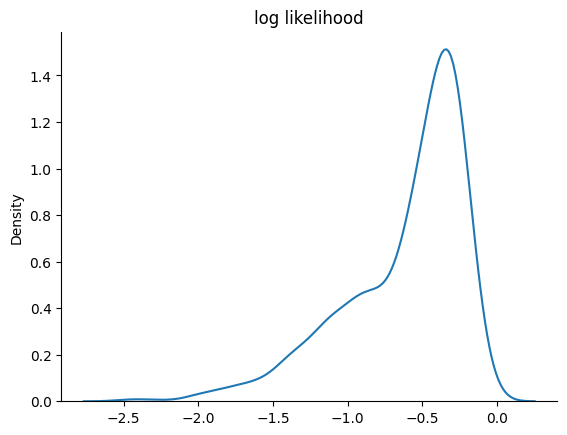

In [83]:
# choose a random sample
plt.title("log likelihood")
t = np.random.randint(0, 4000)
sns.kdeplot(fit['log_lik'][:, t])
sns.despine()

Text(0.5, 0, 'Linear predictor $\\eta_i$')

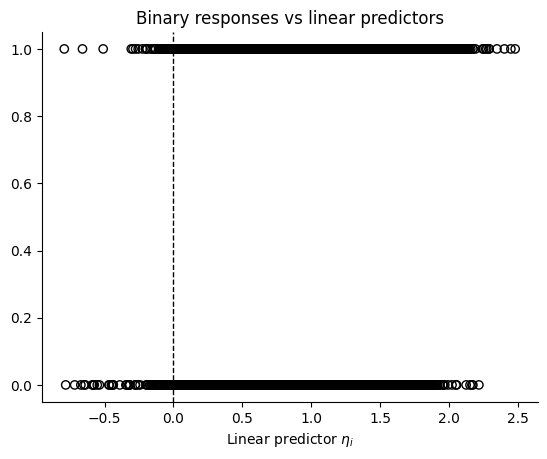

In [12]:

plt.title('Binary responses vs linear predictors')
for sample_idx in range(10):
  # choose a random sample
  t = np.random.randint(0, 4000)
  plt.scatter(fit['eta'][:, t], fit['Y_tilde'][:, t], c='none', edgecolors='k')
sns.despine()
# linear_predictors = summary_table.loc["Inctercept", "mean"] + X * summary_table.loc[["SAT", "GPA", "Income"], "mean"].to_numpy()
plt.axvline(0, c='k', lw=1, ls='--')
plt.xlabel('Linear predictor $\eta_i$')

## Interpretation

When controlling for GPA and income, we find that the coefficient for SAT scores is
$-0.272$. Hence, $e^{-0.272}=0.76$ implies that increases in SAT scores result in a 
$24\%$ reduction in odds that a student gets admitted to their top choice school.

At the same time GPA is associated with a $e^{0.094}=1.098$ or roughly $10\%$ increase in 
the odds of getting admitted to their top choice and income is associated with a $4\%$ increase in odds.

In [13]:
for i in range(fit['beta'].shape[0]):
    print(f"beta[{i}] : {np.exp(np.mean(fit['beta'][i, :]))}")

beta[0] : 0.7077570907391088
beta[1] : 1.180989342880443
beta[2] : 0.884388209481551


In [14]:
def plot_betas(fit):
    """Plot the distribution for betas and alpha"""
    n_bins = 100

    plot_range = fit["beta"].shape[0] + 1
    plt.figure(figsize=(8, 8))

    plt.suptitle("Distribution of Coefficients")
    ax1 = plt.subplot(plot_range, 1, 1)
    sns.histplot(fit['alpha'].flatten(), bins=n_bins);
    plt.vlines(0, 0, 150, colors='C1', ls="--")
    plt.ylabel("Intercept")

    for j in range(1, plot_range):
        plt.subplot(plot_range,1, j + 1, sharex=ax1)
        sns.histplot(fit['beta'][j-1,:], bins=n_bins)
        sns.despine()
        plt.ylabel(feature_cols[j-1])
        plt.vlines(0, 0, 150, colors='C1', ls="--")

    plt.tight_layout(pad=1)

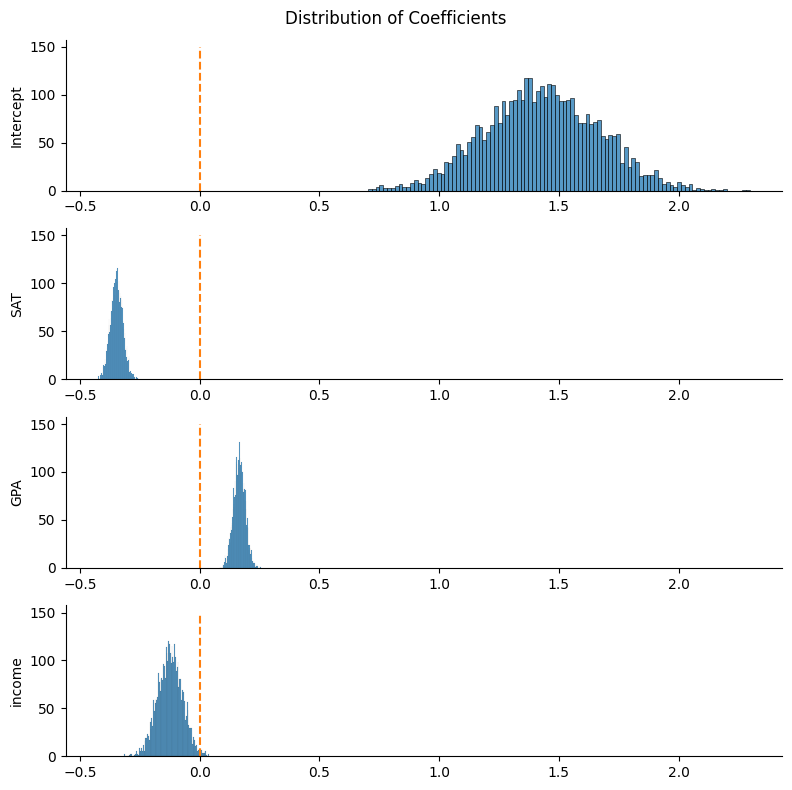

In [15]:
plot_betas(fit)

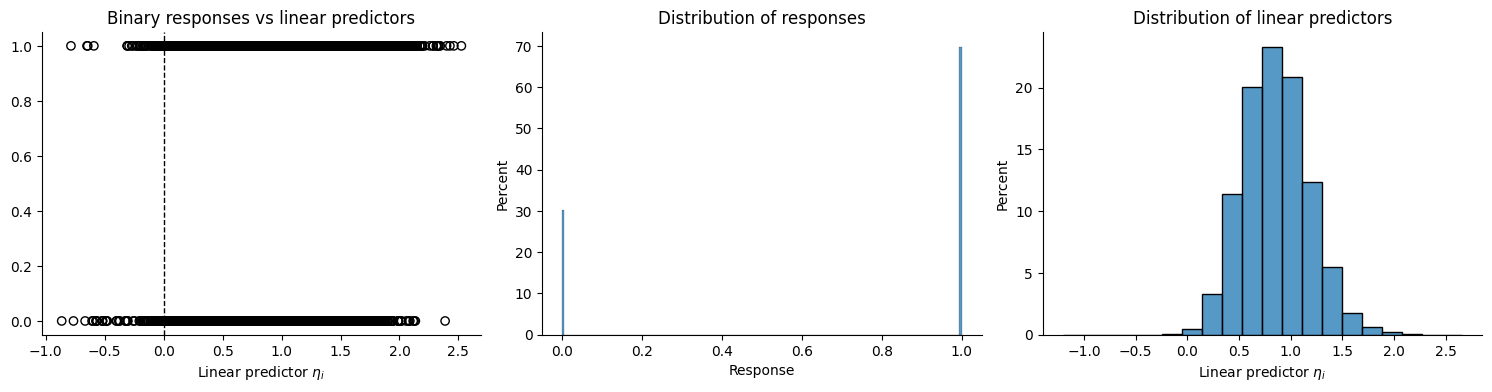

In [16]:
plt.figure(figsize=(15, 4))

plt.subplot(131)
plt.title('Binary responses vs linear predictors')
for sample_idx in range(10):
  # choose a random sample
  t = np.random.randint(0, 4000)
  plt.scatter(fit['eta'][:, t], fit['Y_tilde'][:, t], c='none', edgecolors='k')
sns.despine()
plt.axvline(0, c='k', lw=1, ls='--')
plt.xlabel('Linear predictor $\eta_i$')


plt.subplot(132)
plt.title('Distribution of responses')
sns.histplot(fit['Y_tilde'].flatten(), stat='percent')
sns.despine()
plt.xlabel('Response')

plt.subplot(133)
sns.histplot(fit['eta'].flatten(), bins=20, stat='percent')
sns.despine()
plt.xlabel('Linear predictor $\eta_i$')
plt.title('Distribution of linear predictors')

plt.tight_layout(pad=1)

As we can see there doesn't seem to be a large distinction between linear predictors and the actual binary response.
This could be a result of observations that have the same features, but differ in other ways not captured in the data.
It's most likely a reflection that the model is not comprehensive enough to pick up on the distinctions between applicants.

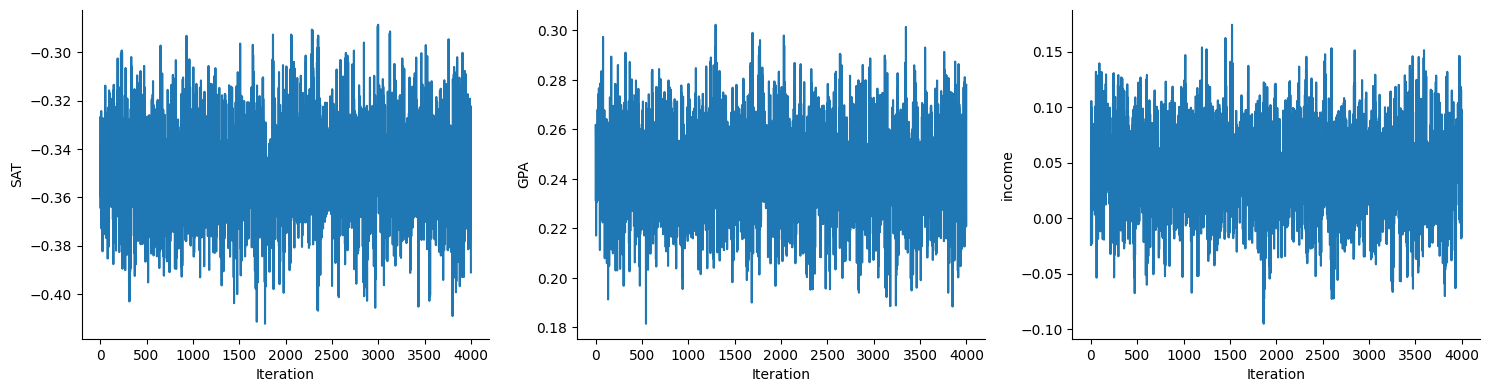

In [134]:
plt.figure(figsize=(15, 4))
plot_range = fit["beta"].shape[0]

for j in range(plot_range):
  plt.subplot(1, 3, j + 1)
  plt.plot(fit['beta'][j,:])
  sns.despine()
  plt.xlabel('Iteration')
  plt.ylabel(feature_cols[j])
  
plt.tight_layout(pad=1)

Use pareto smooted importance sampling leave-one-out cross-validation to estimate predictive performance

In [102]:
loo1, loos1, ks1 = psisloo(fit['log_lik'])
loo1_se = np.sqrt(np.var(loos1, ddof=1)*n)
print('elpd_loo: {:.4} (SE {:.3})'.format(loo1, loo1_se))

elpd_loo: -2.781e+03 (SE 0.576)


In [103]:
# check the number of large (> 0.5) Pareto k estimates
np.sum(ks1 > 0.5)


0

In [135]:
# Use arviz to compute the loo elpd
az.loo(az_fit, pointwise=True)

Computed from 4000 by 20000 log-likelihood matrix

         Estimate       SE
elpd_loo -11574.17    63.21
p_loo        4.20        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     20000  100.0%
 (0.5, 0.7]   (ok)           0    0.0%
   (0.7, 1]   (bad)          0    0.0%
   (1, Inf)   (very bad)     0    0.0%

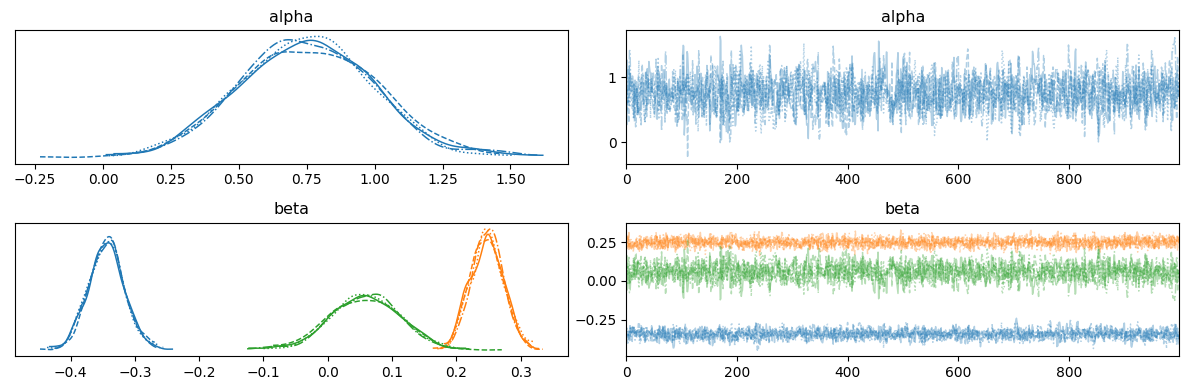

In [105]:
az.plot_trace(az_fit, var_names=["alpha", "beta"])
plt.tight_layout()
plt.show();

In [108]:
fit["y_new"].shape

(1000, 4000)

In [19]:
print(classification_report(y_test, fit["y_new"][:, 72]))

              precision    recall  f1-score   support

           0       0.29      0.30      0.29       294
           1       0.70      0.69      0.70       706

    accuracy                           0.58      1000
   macro avg       0.50      0.50      0.50      1000
weighted avg       0.58      0.58      0.58      1000



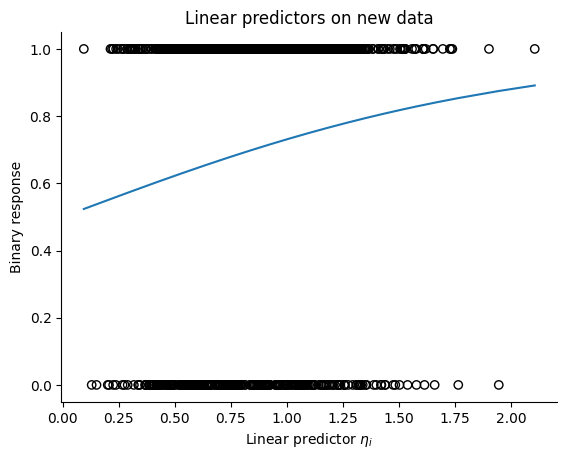

In [22]:
def inv_logit(x):
    """Return the inverse logit."""
    return np.exp(x) / (1 + np.exp(x))

plt.title("Linear predictors on new data")
new_linear_predictors = summary_table.loc["Intercept", "mean"] + X_test @ summary_table.loc[["SAT", "GPA", "Income"], "mean"].to_numpy().T
plt.scatter(new_linear_predictors, y_test, edgecolors='k', c="none")
plt.plot(sorted(new_linear_predictors), inv_logit(sorted(new_linear_predictors)));
plt.xlabel("Linear predictor $\eta_{i}$")
plt.ylabel("Binary response")
sns.despine()

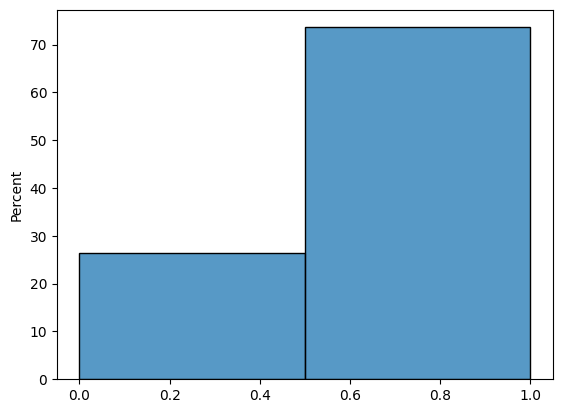

In [146]:
sns.histplot(fit["y_new"][:, 72], bins=2, stat="percent");

<AxesSubplot:ylabel='Percent'>

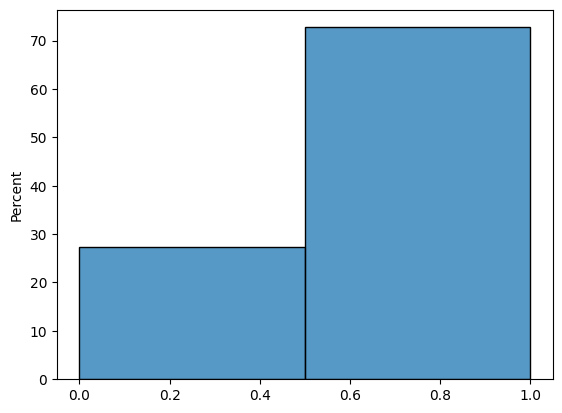

In [147]:
sns.histplot(y_test, bins=2, stat="percent")

In [151]:
sum(y_test)

7274

In [150]:
sum(fit["y_new"][:, 72])

7363.0